In [1]:
from bitalg.visualizer.main import Visualizer

In [2]:
from data import data,process,raw 

In [3]:
vertices=data.loadData(raw.vertices,raw.edges)

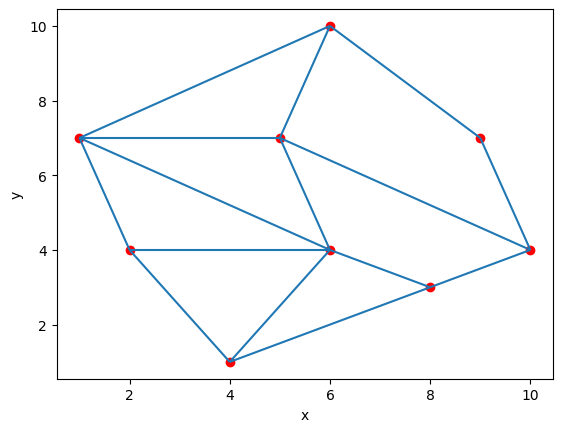

In [4]:
# visualize graph
vis=Visualizer()
points=[(n.x,n.y) for n in vertices]
segments=[]
for n in vertices:
    for out in n.nodesOut:
        segments.append(((n.x,n.y),(out[0].x,out[0].y)))
vis.add_point(points,color='red')
vis.add_line_segment(segments)
vis.show()

In [5]:
process.calculateWeights(vertices)

In [6]:
for vertex in vertices:
    print(f"VERTEX {vertex.x,vertex.y}")
    print("IN: ",end="")
    for (n,w) in vertex.nodesIn:
        print(f"{n} {w}",end=" | ")
    print()
    print("OUT: ",end="")
    for (n,w) in vertex.nodesOut:
        print(f"{n} {w}",end=" | ")
    print()


VERTEX (4, 1)
IN: 
OUT: (8, 3) 3 | (6, 4) 1 | (2, 4) 2 | 
VERTEX (8, 3)
IN: (4, 1) 3 | 
OUT: (10, 4) 2 | (6, 4) 1 | 
VERTEX (2, 4)
IN: (4, 1) 2 | 
OUT: (6, 4) 1 | (1, 7) 1 | 
VERTEX (6, 4)
IN: (8, 3) 1 | (4, 1) 1 | (2, 4) 1 | 
OUT: (5, 7) 1 | (1, 7) 2 | 
VERTEX (10, 4)
IN: (8, 3) 2 | 
OUT: (9, 7) 1 | (5, 7) 1 | 
VERTEX (1, 7)
IN: (6, 4) 2 | (2, 4) 1 | 
OUT: (5, 7) 1 | (6, 10) 2 | 
VERTEX (5, 7)
IN: (10, 4) 1 | (6, 4) 1 | (1, 7) 1 | 
OUT: (6, 10) 3 | 
VERTEX (9, 7)
IN: (10, 4) 1 | 
OUT: (6, 10) 1 | 
VERTEX (6, 10)
IN: (9, 7) 1 | (5, 7) 3 | (1, 7) 2 | 
OUT: 
